<a href="https://colab.research.google.com/github/w1767/w1767/blob/main/Normalised_Log_difference_NBeats_Forecasting_VVIX_VIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
#transformers for time series data
# n-beats: neural basis expansion analysis for interpretable time series forecasting
# detrend data
#remove seasonality
#turn into supervised learning process
#get baseline, important for ML problems start with simple naive baseline = predict the last time step as the next step
#being able to quantify our confidence in forecasting referred to as uncertainty, confidence interval, prediction interval
#UBER uses Bayesian or MC dropout
# one way to do this is Monte Carlo dropout is to use dropout at inference and run multiple simulations
#two types of uncertainty
#1. coconut uncertainty - get hit on a beach by coconut = epistemic uncertainty/hard to estimate
#2. subway uncertainty - train should appear at 5pm but it shows up 1-2 min either side= aleatory uncertainty
#aleatory uncertainty = data uncertainty
#weather = predict every day 
#nate silver vs Nasim Taleb
# political outcomes = open system, many different variables
#silver says that last outcome is all that matters
#taleb says tail risk
#WRMSSE = WEIGHT ROOT MEAN SQUARE ERROR
#kaggle 101 = GOT A TABULAR DATA? THEN STACK TOGETHER ENSEMBLES OF LIGHTGBM/XGBOOST
#replicate and modify https://arxiv.org/pdf/1905.10437.pdf 

In [80]:
!wget https://github.com/ElementAI/N-BEATS

--2022-04-30 15:23:59--  https://github.com/ElementAI/N-BEATS
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘N-BEATS.1’

N-BEATS.1               [ <=>                ] 176.56K  --.-KB/s    in 0.04s   

2022-04-30 15:23:59 (4.57 MB/s) - ‘N-BEATS.1’ saved [180797]



In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/MyDrive/PhD research/VIX daily.csv"

In [82]:
#check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [83]:
#import pandas
import pandas as pd
#because data has date component, pandas will parse the dates using the parse_dates parameters
df=pd.read_csv("/content/drive/MyDrive/PhD research/VIX daily.csv",
                  parse_dates=["Date"],
                  index_col=["Date"]) # parse the date column and tell pandas that column 1 is a datetime
df.head()

,Last Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
Date,,,,,,,
2022-04-20,21.19,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-19,21.37,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-18,22.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-14,22.70,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-13,21.82,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df

,Last Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
Date,,,,,,,
2022-04-20,21.19,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-19,21.37,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-18,22.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-14,22.70,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-13,21.82,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df.isnull().any()

Last Price    True
Unnamed: 2    True
Unnamed: 3    True
Unnamed: 4    True
Unnamed: 5    True
Unnamed: 6    True
Unnamed: 7    True
dtype: bool

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12247 entries, 2022-04-20 to NaT
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Last Price  8136 non-null   float64
 1   Unnamed: 2  0 non-null      float64
 2   Unnamed: 3  0 non-null      float64
 3   Unnamed: 4  0 non-null      float64
 4   Unnamed: 5  0 non-null      float64
 5   Unnamed: 6  0 non-null      float64
 6   Unnamed: 7  0 non-null      float64
dtypes: float64(7)
memory usage: 765.4 KB


In [87]:
len(df)

12247

In [99]:
# only last price for each date
VIX_daily = pd.DataFrame(df["Last Price"]).rename(columns={"Last Price": "Price"})
VIX_daily.head()

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82


In [100]:
VIX_daily.isnull().any()

Price    True
dtype: bool

In [101]:
VIX_daily=VIX_daily.dropna()

In [102]:
import numpy as np

VIX_daily['log VIX']=np.log(VIX_daily['Price'])

In [104]:
VIX_daily['pct change']=VIX_daily['log VIX'].diff()

In [105]:
VIX_daily

,Price,log VIX,pct change
Date,,,
2022-04-20,21.19,3.053529,NaN
2022-04-19,21.37,3.061988,0.008459
2022-04-18,22.17,3.098740,0.036752
2022-04-14,22.70,3.122365,0.023625
2022-04-13,21.82,3.082827,-0.039538
...,...,...,...
1990-08-01,20.26,3.008648,-0.091444
1990-05-01,20.11,3.001217,-0.007431
1990-04-01,19.22,2.955951,-0.045266


In [115]:
VIX_daily=VIX_daily.dropna()

In [119]:
import pandas as pd

df = pd.DataFrame(VIX_daily)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8135 entries, 2022-04-19 to 1990-02-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       8135 non-null   float64
 1   log VIX     8135 non-null   float64
 2   pct change  8135 non-null   float64
dtypes: float64(3)
memory usage: 254.2 KB


In [121]:
VIX_daily = pd.DataFrame(df["pct change"]).rename(columns={"pct change": "Returns"})
VIX_daily.head()

,Returns
Date,
2022-04-19,0.008459
2022-04-18,0.036752
2022-04-14,0.023625
2022-04-13,-0.039538
2022-12-04,0.106002


ADF test to identify if the Log VIX returns are stationary or not.

In [123]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(VIX_daily)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ValueError: ignored

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [47]:
VIX_daily = pd.DataFrame(df["Last Price"]).rename(columns={"Last Price": "Price"})

In [45]:
timesteps = []
VIX_daily = []

In [48]:
VIX_daily

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82
...,...
NaT,NaN
NaT,NaN
NaT,NaN


In [43]:
#Plot
import matplotlib.pyplot as plt
VIX_daily['pct_change'].plot(figsize=(10, 7))
plt.ylabel("VIX")
plt.title("VIX daily from 1990 to 2022", fontsize=16)
plt.legend(fontsize=10);

TypeError: ignored

In [183]:
# Only want closing price for each day 

In [184]:
# Importing and formatting historical data with Python
#import csv
#from datetime import datetime

#timesteps = []
#vix_price = []
#with open("/content/drive/MyDrive/PhD research/VIX daily.csv", "r") as f:
#  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
#  next(csv_reader) # skip first line (this gets rid of the column titles)
#  for line in csv_reader:
#    timesteps.append(datetime.strptime(line[1], "%d/%m/%Y")) # get the dates as dates (not strings), strptime = string parse time
#    vix_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
#timesteps[:10], vix_price[:10]


In [185]:
#to_plt=df.sort_values(by = 'Date').set_index('Date')

In [186]:
timesteps = []
prices = []

In [187]:
#turn DataFrame index and column into numpy arrays
timesteps = VIX_daily.index.to_numpy()
prices = VIX_daily.to_numpy()
timesteps[:10], prices[:10]

(array(['2022-04-19T00:00:00.000000000', '2022-04-18T00:00:00.000000000',
        '2022-04-14T00:00:00.000000000', '2022-04-13T00:00:00.000000000',
        '2022-12-04T00:00:00.000000000', '2022-11-04T00:00:00.000000000',
        '2022-08-04T00:00:00.000000000', '2022-07-04T00:00:00.000000000',
        '2022-06-04T00:00:00.000000000', '2022-05-04T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([ 0.0084587 ,  0.03675195,  0.0236249 , -0.03953794,  0.10600192,
         0.00452396, -0.14124026,  0.01826321,  0.02520179, -0.04962762]))

In [188]:
import sklearn
from sklearn.model_selection import train_test_split 
X_train = []
y_train = []
X_test = []
y_test = []

#create train, test, validate sets
split_size = int(0.2 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[split_size:], prices[split_size:]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[:split_size], prices[:split_size]

len(X_train), len(X_test), len(y_train), len(y_test)


(6508, 1627, 6508, 1627)

In [189]:
X_test, y_test

(array(['2022-04-19T00:00:00.000000000', '2022-04-18T00:00:00.000000000',
        '2022-04-14T00:00:00.000000000', ...,
        '2015-04-11T00:00:00.000000000', '2015-03-11T00:00:00.000000000',
        '2015-02-11T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ 0.0084587 ,  0.03675195,  0.0236249 , ...,  0.03010699,
        -0.06458151, -0.02718885]))

In [190]:
X_train, y_train

(array(['2015-10-30T00:00:00.000000000', '2015-10-29T00:00:00.000000000',
        '2015-10-28T00:00:00.000000000', ...,
        '1990-04-01T00:00:00.000000000', '1990-03-01T00:00:00.000000000',
        '1990-02-01T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ 0.06299139, -0.03099979, -0.01935098, ..., -0.0452658 ,
        -0.05507941, -0.05363973]))

In [191]:
#plot train_test_split
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("VIX")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

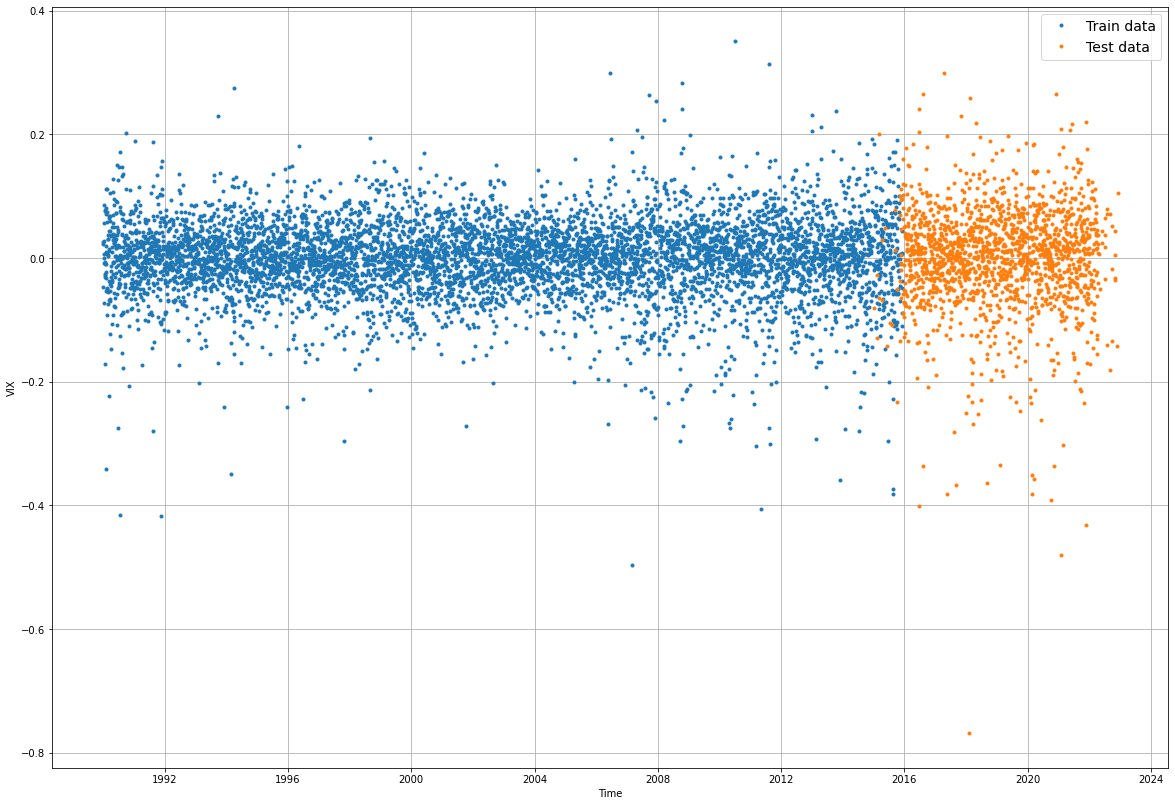

In [192]:
# plot train_test_split
plt.figure(figsize=(20, 14))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [193]:
#Forecasting Experiments
#horizon is the number of steps we are going to predict into the future
#window is the number of timesteps from past used to predict horizon
#for example to predict VIX for 1 day in the future use the previous 7 days in the past. 
# we will see how the models work without taking log differences and normalisation first. then we will
#do the log differences and normalise the data




In [194]:
# Model 1. Naive forecast (baseline)
#use previous time value to predict the next timestep value
# y(t+1) = y(t) -> in economic theory this is called martingale


In [195]:
# create a naive forecast
naive_forecast = y_test[:-1] # naive forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10] # first 10 and last 10

(array([ 0.0084587 ,  0.03675195,  0.0236249 , -0.03953794,  0.10600192,
         0.00452396, -0.14124026,  0.01826321,  0.02520179, -0.04962762]),
 -0.03676089597506982)

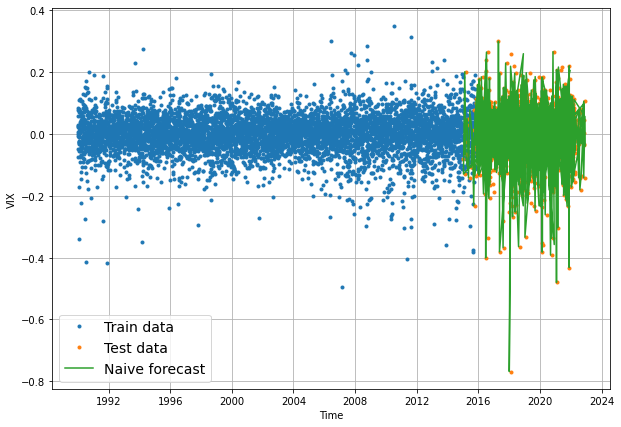

In [196]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

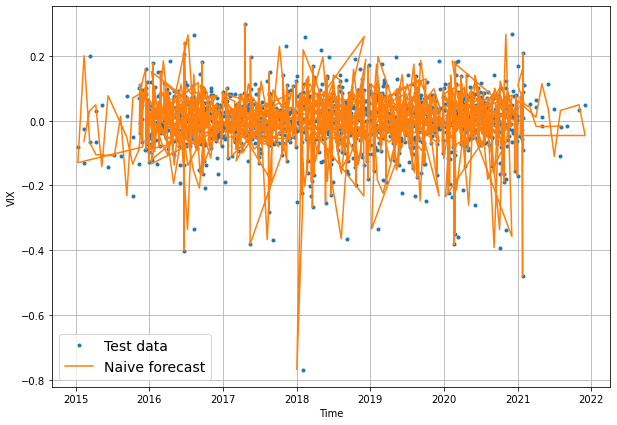

In [197]:
#ZOOM IN
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

#Evaluating forecasts
#how our model's predictions y_pred compare against the actual values y_true 

In [198]:
import tensorflow as tf

In [199]:
#calculate MASE
# https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


In [200]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
#account for different sized metrics for longer horizons and reduce to a single number

  if mae.ndim > 0: # if mae isnt a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [201]:
#Baselines forecast 
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.08648081,
 'mape': 421354.2,
 'mase': 0.9995861,
 'mse': 0.01531637,
 'rmse': 0.12375933}

In [202]:
#the naive forecast is on average 1.17 different from the actual data
#calculate average of Vix
# so the naive forecast is off by more than 10% on average
tf.reduce_mean(y_test).numpy()

-0.0002481959116109163

why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results. We will use ADFT to check for autocorrelation. This is why we need to take Log differences.

In [203]:
#Windowing dataset
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [204]:
# create a function to label windowed data
def get_labelled_window(x, horizon=1):
  """
  Creates labels for windowed dataset.

  e.g. if horizon =1 (default)
  Input:[1,2,3,4,5,6] -> output: ([1,2,3,4,5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [205]:
# test out the window labelling
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:] 

In [206]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [207]:
# Create function to view NumPy arrays as windows 
# reference https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [208]:
import numpy as np

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(8128, 8128)

In [209]:
# check first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [ 0.0084587   0.03675195  0.0236249  -0.03953794  0.10600192  0.00452396
 -0.14124026] -> Label: [0.01826321]
Window: [ 0.03675195  0.0236249  -0.03953794  0.10600192  0.00452396 -0.14124026
  0.01826321] -> Label: [0.02520179]
Window: [ 0.0236249  -0.03953794  0.10600192  0.00452396 -0.14124026  0.01826321
  0.02520179] -> Label: [-0.04962762]


In [210]:
# view the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [ 0.08556285 -0.06671756 -0.20614198  0.11261593 -0.01075279 -0.09144379
 -0.0074313 ] -> Label: [-0.0452658]
Window: [-0.06671756 -0.20614198  0.11261593 -0.01075279 -0.09144379 -0.0074313
 -0.0452658 ] -> Label: [-0.05507941]
Window: [-0.20614198  0.11261593 -0.01075279 -0.09144379 -0.0074313  -0.0452658
 -0.05507941] -> Label: [-0.05363973]


In [211]:
#function that takes a full set of windows and their labels and splits them into train and test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits. 
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train and 20% test.
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


In [212]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(6502, 1626, 6502, 1626)

In [213]:
# check to see the first 5 samples of the training windows and labels
train_windows[:5], train_labels[:5]

(array([[ 0.0084587 ,  0.03675195,  0.0236249 , -0.03953794,  0.10600192,
          0.00452396, -0.14124026],
        [ 0.03675195,  0.0236249 , -0.03953794,  0.10600192,  0.00452396,
         -0.14124026,  0.01826321],
        [ 0.0236249 , -0.03953794,  0.10600192,  0.00452396, -0.14124026,
          0.01826321,  0.02520179],
        [-0.03953794,  0.10600192,  0.00452396, -0.14124026,  0.01826321,
          0.02520179, -0.04962762],
        [ 0.10600192,  0.00452396, -0.14124026,  0.01826321,  0.02520179,
         -0.04962762, -0.12440261]]), array([[ 0.01826321],
        [ 0.02520179],
        [-0.04962762],
        [-0.12440261],
        [ 0.05551163]]))

In [214]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

In [215]:
# Build a modelling checkpoint to compare the best model's betst performance
# implement checkpoint callback
# the ModelCheckpoint callback will monitor model's performance during training and save the best model to file setting 
# save_best_only = True
#create ModelCheckpoint callback to save a model to a specified filename



In [216]:
import os
#create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only = True)

In [217]:
#CONV1D model can be used for seq2seq (sequence to sequence) problem. use previous t-x days and the output is the next day.
# i.e. many to one problem


In [218]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [219]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(8128, 8128)

In [220]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(6502, 1626, 6502, 1626)

Since we're going to be using Conv1D layers, we need to make sure our input shapes are correct. The Conv1D layer in TensorFlow takes an input of: 
(batch_size, timesteps, input_dim).

In this case, the batch_size (by default this is 32) is handled for us but the other values will be:

timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of VIX.

input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)
Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.
have to make sure input shape is correct. For windowed dataset, if we need to reshape dataset size within a model we can use a Lambda layer...
tf.keras.layers.Lambda(lambda x: tf.expand_dim(x, axis=1)) 


In [221]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [222]:
#To fix this, we could adjust the shape of all of our train_windows or we could use a tf.keras.layers.Lamdba
#(called a Lambda layer) to do this for us in our model.
#The Lambda layer wraps a function into a layer which can be used with a model.
import keras
from keras import layers

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[ 0.0084587 ]
 [ 0.03675196]
 [ 0.0236249 ]
 [-0.03953794]
 [ 0.10600192]
 [ 0.00452396]
 [-0.14124025]]


In [223]:
tf.random.set_seed(42)
#create model https://keras.io/api/layers/convolution_layers/convolution1d/
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
model = tf.keras.Sequential([
                             #create lambda layer to reshape to reshape inputs
                             layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size
                             layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu"),
                             layers.Dense(HORIZON)
], name = "model_conv1D")
#Compile
model.compile(loss="mae",
              optimizer=tf.keras.optimizers.Adam())
#Fit model
model.fit(train_windows,
          train_labels,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(test_windows, test_labels),
          callbacks=[create_model_checkpoint(model_name=model.name)])


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_conv1D/assets


In [224]:
model.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            6400      
                                                                 
 dense_172 (Dense)           (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [225]:
#Load the best performing Conv1D model and evaluate it on test data
model = tf.keras.models.load_model("model_experiments/model_conv1D")
model.evaluate(test_windows, test_labels)

51/51 [==============================] - 0s 4ms/step - loss: 0.0412


0.04122556373476982

In [226]:
#Making forecasts with a model
def make_preds(model, input_data):
  """Uses model to make predictions on input_data.
  Parameters
  ------------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #returns 1D array of prediction

In [227]:
# Make predictions
import keras
model_preds = make_preds(model, test_windows)
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.01043752,  0.01109818,  0.01023918,  0.01310468,  0.00486793,
        0.00425699,  0.00690514, -0.00067725, -0.00054517,  0.00845481],
      dtype=float32)>

In [228]:
#evaluate predictions
model_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_preds)
model_results

{'mae': 0.041225564,
 'mape': 66925.66,
 'mase': 0.6722016,
 'mse': 0.0032436668,
 'rmse': 0.056953195}

In [229]:
#compare to naive results, Cov1D seems pretty good
naive_results

{'mae': 0.08648081,
 'mape': 421354.2,
 'mase': 0.9995861,
 'mse': 0.01531637,
 'rmse': 0.12375933}

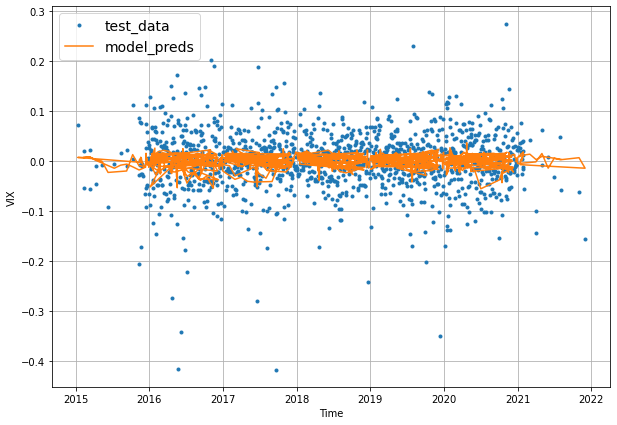

In [230]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_preds, start=offset, format="-", label="model_preds") 

Model 2: RNN LSTM
The tf.keras.layers.LSTM() layer takes a tensor with [batch, timesteps, feature] dimensions.

As mentioned earlier, the batch dimension gets taken care of for us but our data is currently only has the feature dimension (WINDOW_SIZE).

To fix this, just like we did with the Conv1D model, we can use a tf.keras.layers.Lambda() layer to adjust the shape of our input tensors to the LSTM layer.

In [231]:
tf.random.set_seed(42)

# Build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
print(x.shape)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
#x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
print(x.shape)
# Add another optional dense layer -> add more of these to see if they improve model performance
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=output, name="model_2_lstm")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

(None, 1, 7)


(None, 1, 128)
INFO:tensorflow:Assets written to: model_experiments/model_2_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_lstm/assets


In [232]:
#load the best epoch and evaluate the test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_lstm/")
model_2.evaluate(test_windows, test_labels)

51/51 [==============================] - 1s 4ms/step - loss: 0.0413


0.04125995188951492

In [233]:
#make predictions with LSTM model
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10]


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00302942, 0.00426322, 0.00420105, 0.0035438 , 0.00283149,
       0.0031114 , 0.0012703 , 0.00188242, 0.00095675, 0.000584  ],
      dtype=float32)>

In [234]:
#evaluate model 2 predictions
# very similare to Con1D and slightly better than martingale, naive model
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 0.041259952,
 'mape': 21204.44,
 'mase': 0.6727623,
 'mse': 0.0033302207,
 'rmse': 0.057708066}

In [235]:
naive_results

{'mae': 0.08648081,
 'mape': 421354.2,
 'mase': 0.9995861,
 'mse': 0.01531637,
 'rmse': 0.12375933}

In [236]:
model_results

{'mae': 0.041225564,
 'mape': 66925.66,
 'mase': 0.6722016,
 'mse': 0.0032436668,
 'rmse': 0.056953195}

Model 3: N-BEATS ALGORITHM https://arxiv.org/pdf/1905.10437.pdf. 
N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm INCREASES the number of layers. We are going to replicate the generic architecture of the N-BEATS ALGo. 


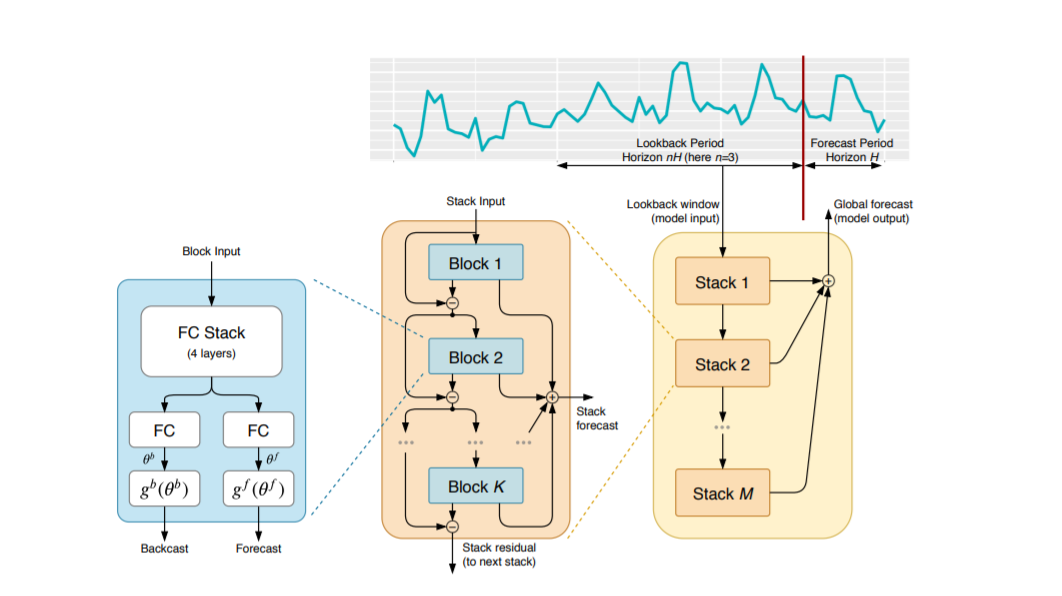

Source: https://medium.com/@jonathanbechtel/kerasbeats-an-easy-way-to-use-n-beats-in-keras-395b24c5cc28

1. Create a custom layer for the NBeatsBlock by subclassing tf.keras.layers.Layer.
Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks).
2. Implement a custom architecture using the Functional API


In [342]:
#Build and test N-BEATS block layers
#FC = Fully Connected layer
#horizon =forwardcast(H)
# backcast = backcast(2H to 7H)
# block( 4 x FC Stack) -> stack(n Blocks) -> full architecture (m Stacks)
#create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, #constructor takes all the hyperparameters for the layer)
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)

      super().__init__(**kwargs)
      self.input_size = input_size
      self.theta_size = theta_size
      self.horizon = horizon
      self.n_neurons = n_neurons
      self.n_layers = n_layers

      #Block containes stack of 4 fully connected layers each has ReLU activation
      self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
      #Output of block is a theta layer with linear activation
      self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

#theta produces backward and forward expandsion coefficients
  
  def call(self, inputs): # the call method is what runs when the layer is called, defines the forward computation. 
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    #Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    #theta_f = tf.keras.activation.linear(x) #forward W*h
    #theta_b = tf.keras.activation.linear(x) #backward 
    return backcast, forecast
    #return theta_f, theta_b


Setting up the NBeatsBlock custom layer we see:

The class inherits from tf.keras.layers.Layer (this gives it all of the methods assosciated with tf.keras.layers.Layer)
The constructor (def __init__(...)) takes all of the layer hyperparameters as well as the **kwargs argument.
The **kwargs argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, input_shape, trainable and name.
In the constructor, the block architecture layers are created:
The hidden layers are created as a stack of fully connected with n_nuerons hidden units layers with ReLU activation.
The theta layer uses theta_size hidden units as well as linear activation.
The call() method is what is run when the layer is called:
It first passes the inputs (the historical VIX data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: input_size) and forecast (forward predictions, shape: horizon) are returned.

In [343]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [344]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [345]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.3992805   0.64474386 -0.3948719  -1.1792767  -0.63454235 -1.2073143
  0.61047304]
Forecast: 0.07165676355361938


Prepare data for the N-BEATS algorithm using tf.data.
Use tf.data API
Because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of VIX just as we did above.

In [346]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [347]:
prices

array([ 0.0084587 ,  0.03675195,  0.0236249 , ..., -0.0452658 ,
       -0.05507941, -0.05363973])

In [362]:
VIX_daily = pd.DataFrame(df["Last Price"]).rename(columns={"Last Price": "Price"})
VIX_daily.head()

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82


In [350]:
VIX_daily=np.log(VIX_daily['Price'])

In [351]:
VIX_daily=VIX_daily.diff()

In [361]:
VIX_daily

Date
2022-04-19    0.008459
2022-04-18    0.036752
2022-04-14    0.023625
2022-04-13   -0.039538
2022-12-04    0.106002
                ...   
1990-08-01   -0.091444
1990-05-01   -0.007431
1990-04-01   -0.045266
1990-03-01   -0.055079
1990-02-01   -0.053640
Name: Price, Length: 8135, dtype: float64

In [355]:
VIX_daily=VIX_daily.dropna()

In [356]:
VIX_daily.head()

Date
2022-04-19    0.008459
2022-04-18    0.036752
2022-04-14    0.023625
2022-04-13   -0.039538
2022-12-04    0.106002
Name: Price, dtype: float64

In [304]:
VIX_daily.columns=['Date', 'Price']

In [363]:
VIX_daily

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82
...,...
NaT,NaN
NaT,NaN
NaT,NaN


In [364]:
#add windowed columns
VIX_daily_nbeats = VIX_daily.copy()
for i in range(WINDOW_SIZE):
  VIX_daily_nbeats[f"Price+{i+1}"] = VIX_daily_nbeats["Price"].shift(periods=i+1)
VIX_daily_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2022-08-04,21.16,24.37,24.26,21.82,22.70,22.17,21.37,21.19
2022-07-04,21.55,21.16,24.37,24.26,21.82,22.70,22.17,21.37
2022-06-04,22.10,21.55,21.16,24.37,24.26,21.82,22.70,22.17
2022-05-04,21.03,22.10,21.55,21.16,24.37,24.26,21.82,22.70
2022-04-04,18.57,21.03,22.10,21.55,21.16,24.37,24.26,21.82


In [280]:
axis=1

In [281]:
print(axis)

1


In [282]:
VIX_daily

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82
...,...
NaT,NaN
NaT,NaN
NaT,NaN


In [318]:
# make features and labels
X = VIX_daily_nbeats.dropna().drop("Price", axis=1)
y = VIX_daily_nbeats.dropna()["Price"]

#Make train and test sets

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(6503, 6503, 1626, 1626)

convert Train_Test into TensorFlow tf.data.Dataset's to ensure they run as fast as possible whilst training.

We'll do this by:

Turning the arrays in tensor Datasets using tf.data.Dataset.from_tensor_slices().
From_tensor_slices() works best when your data fits in memory, for extremely large datasets, you'll want to look into using the TFRecord format.
Combine the labels and features tensors into a Dataset using tf.data.Dataset.zip().
Batch and prefetch the Datasets using batch() and prefetch()
Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible


In [319]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

#Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Notice the input shape for the features (None, 7), the None leaves space for the batch size where as the 7 represents the WINDOW_SIZE.

Table 18 from N-BEATS paper describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.

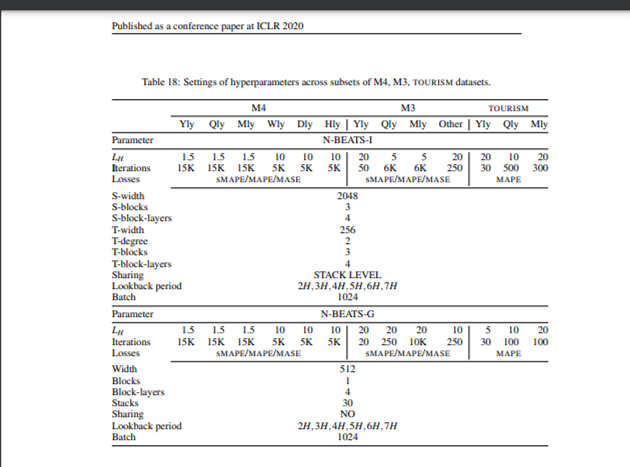

In [320]:
#instantiate variables using CAPS and use throughout the experiment
#Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:

tf.keras.layers.subtract(inputs) - subtracts list of input tensors from each other
tf.keras.layers.add(inputs) - adds list of input tensors to each other

In [80]:
#make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

#Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")


Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of residual stacking or residual connections was revealed in Deep Residual Learning for Image Recognition where the authors were able to build a deeper but less complex neural network (this is what introduced the popular ResNet architecture) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

Subtract the backcast outputs from a previous block from the backcast inputs to the current block
Add the forecast outputs from all blocks together in a stack

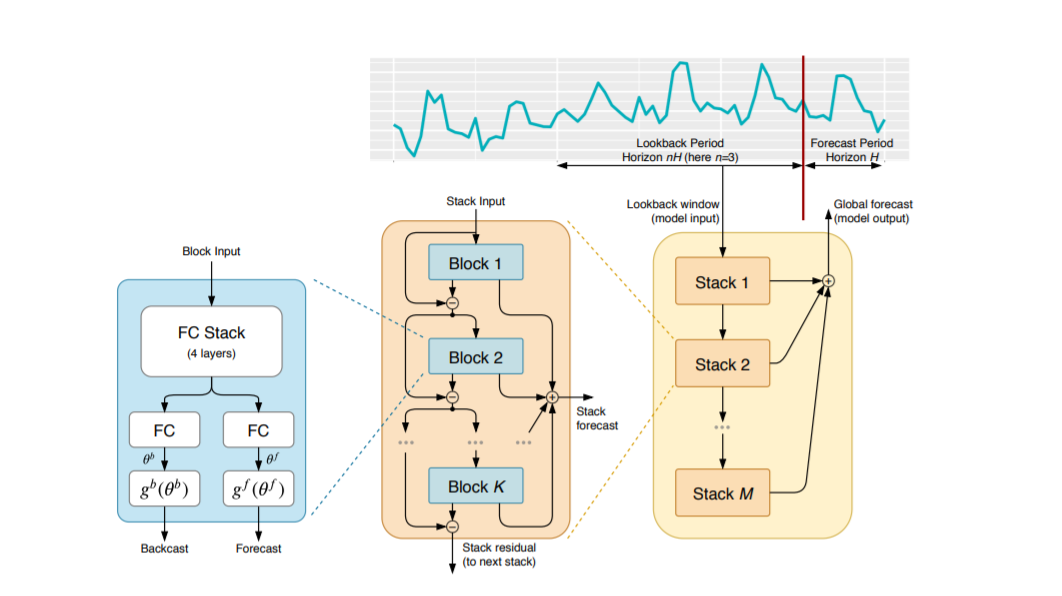

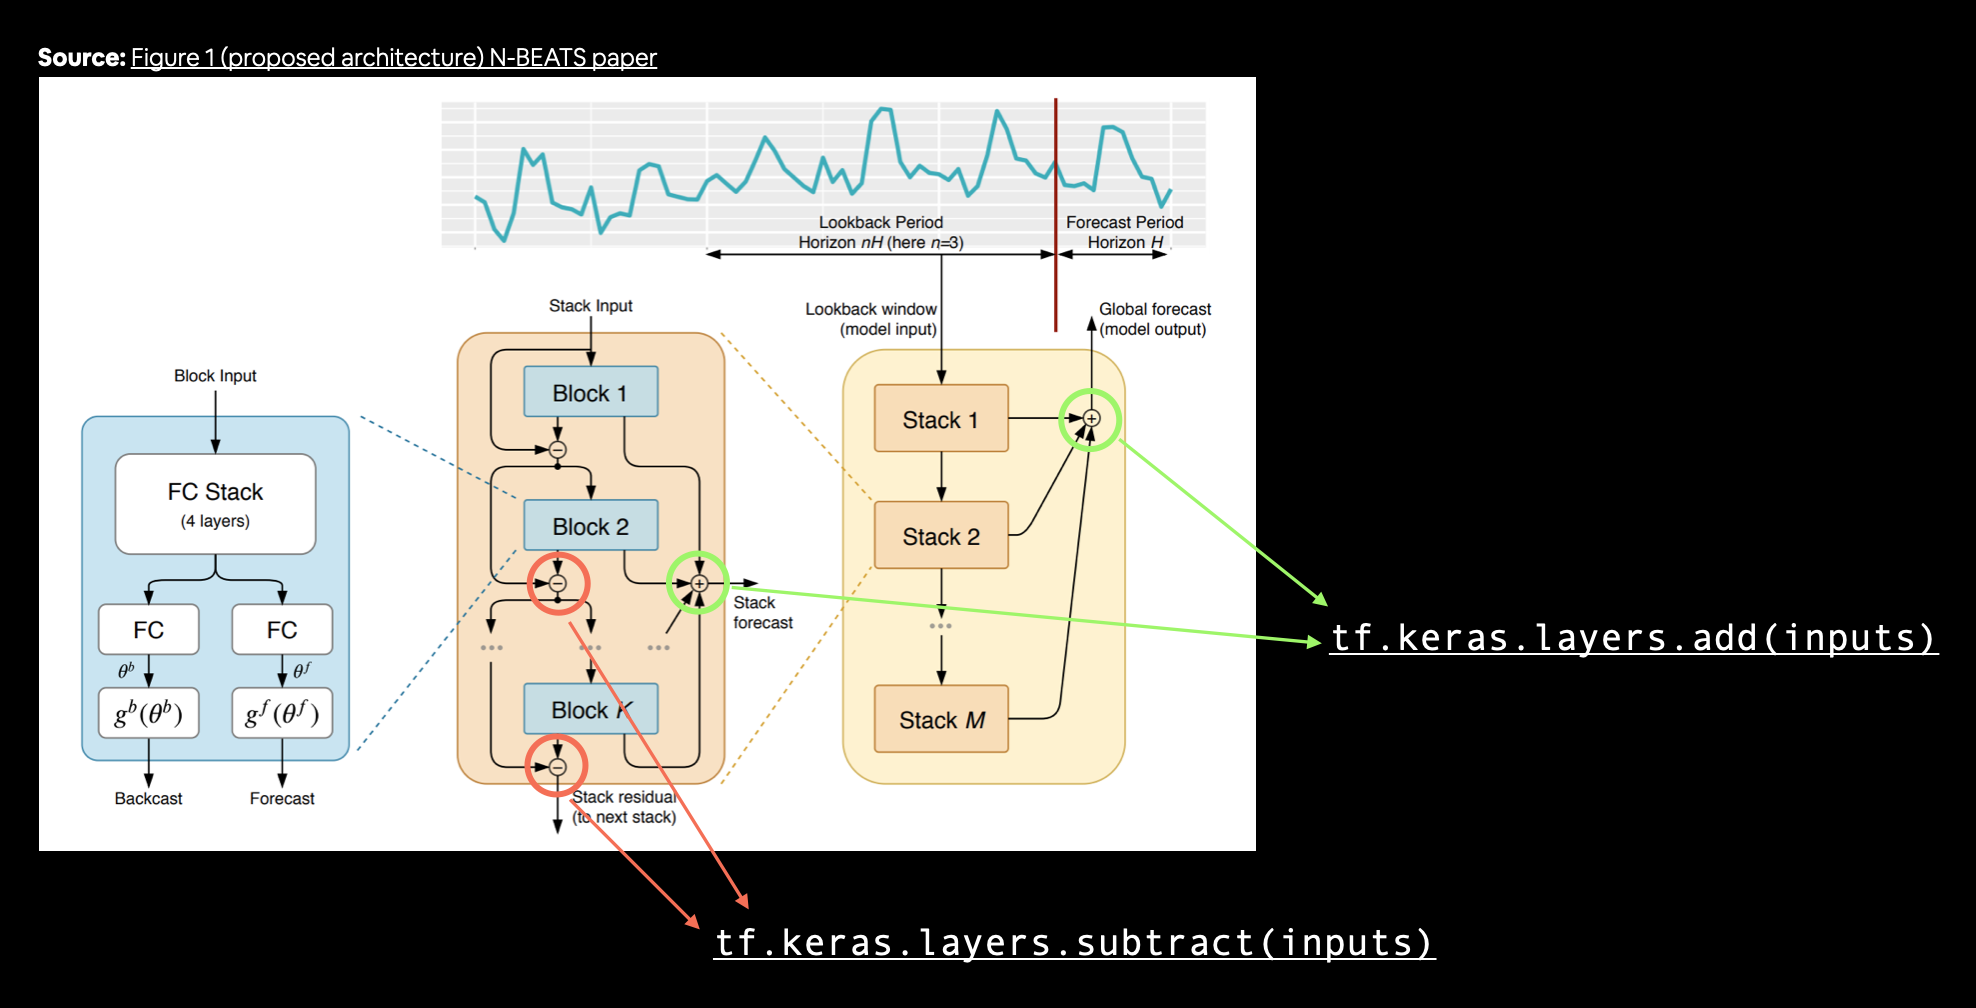

Building, compiling and fitting the N-BEATS algorithm.
1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1).
4. Use a for loop to create stacks of block layers.
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts.
5. Create the double residual stacking using subtract and add layers.
6. Put the model inputs and outputs together using tf.keras.Model().
7. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper).
8. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
a. tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for long period of time without improvement).
b. tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [81]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [82]:
!pip install tensorflow-addons==0.9.1

     |████████████████████████████████| 1.0 MB 5.1 MB/s 


In [83]:
%%time

tf.random.set_seed(42)
#setup NBeats block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")
# create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

#create initial backcast and forecast input (backward predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

#add in subtraction residual link    
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

#create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): #FIRST STACK IS ALREADY CREATED ABOVE

# Use the NBeatsBlock to calculate the backcast as well as block forecast
     backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)


#create the double residual stacking
residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# put the stack model together

model_3 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_3_N_Beats")

# compile with MAE loss and Optimiser
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

#fit the model with early stopping and reduceLROnPlateau callbacks
model_3.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1, # prevent large amounts of training outputs)
             # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])   

Epoch 1/5000
7/7 [==============================] - 2s 92ms/step - loss: 11.0155 - mae: 11.0155 - mse: 191.7126 - val_loss: 4.0194 - val_mae: 4.0194 - val_mse: 19.3266 - lr: 0.0010
Epoch 2/5000
7/7 [==============================] - 0s 42ms/step - loss: 3.7490 - mae: 3.7490 - mse: 24.7781 - val_loss: 2.0717 - val_mae: 2.0717 - val_mse: 6.2671 - lr: 0.0010
Epoch 3/5000
7/7 [==============================] - 0s 37ms/step - loss: 2.1533 - mae: 2.1533 - mse: 9.7300 - val_loss: 1.0453 - val_mae: 1.0453 - val_mse: 2.2509 - lr: 0.0010
Epoch 4/5000
7/7 [==============================] - 0s 37ms/step - loss: 1.7105 - mae: 1.7105 - mse: 6.5746 - val_loss: 0.9691 - val_mae: 0.9691 - val_mse: 1.9007 - lr: 0.0010
Epoch 5/5000
7/7 [==============================] - 0s 38ms/step - loss: 1.4586 - mae: 1.4586 - mse: 4.9200 - val_loss: 0.7991 - val_mae: 0.7991 - val_mse: 1.4053 - lr: 0.0010
Epoch 6/5000
7/7 [==============================] - 0s 34ms/step - loss: 1.3087 - mae: 1.3087 - mse: 3.9894 - val_

In [84]:
# evaluate N-Beats model on the test dataset
model_3.evaluate(test_dataset)

2/2 [==============================] - 0s 10ms/step - loss: 0.6832 - mae: 0.6832 - mse: 1.0472


[0.6831793189048767, 0.6831793189048767, 1.0472147464752197]

In [85]:
#make prediction with N-Beats
model_3_preds = make_preds(model_3, test_dataset)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([16.241049, 16.903893, 16.175583, 16.300251, 16.817795, 16.19813 ,
       16.073252, 17.076242, 16.938995, 15.69199 ], dtype=float32)>

In [86]:
model_3_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_3_preds)
model_3_results

{'mae': 0.6831793,
 'mape': 4.139392,
 'mase': 0.9939533,
 'mse': 1.0472149,
 'rmse': 1.0233352}

Plotting the N-BEATS architecture we've created using
tensorflow.keras.utils.plot_model().

In [87]:
naive_results
#N-beats model seems to do quite well compared to naive model but it is about the same as model conv1d and model lstm.

{'mae': 1.1792436,
 'mape': 5.9647007,
 'mase': 0.9994789,
 'mse': 4.284379,
 'rmse': 2.069874}

In [88]:
model_results

{'mae': 0.67953795,
 'mape': 4.123185,
 'mase': 0.9886555,
 'mse': 1.0498621,
 'rmse': 1.0246278}

In [89]:
model_2_results

{'mae': 0.6810504,
 'mape': 4.1368423,
 'mase': 0.990856,
 'mse': 1.0438161,
 'rmse': 1.0216732}

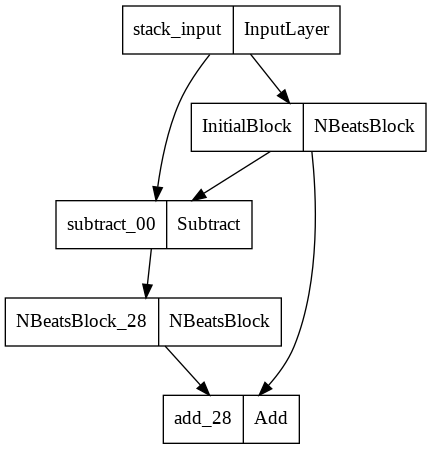

In [90]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_3)

Comparison of model_3 (N-BEATS replica model make with Keras Functional API) versus actual N-BEATS architecture diagram.


In [91]:
#save model
model_3.save(model_3.name)

INFO:tensorflow:Assets written to: model_3_N_Beats/assets


INFO:tensorflow:Assets written to: model_3_N_Beats/assets


Creating an ensemble.
For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see section 3.4) to achieve the results they did using a combination of:

Different loss functions (sMAPE, MASE and MAPE)
Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)
The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can take the average or median of many different models.

It wouldn't make sense to train the same model 10 times on the same data and then average the predictions.

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results.

What I mean by this is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on.

However, the process it adjusts these patterns is often a form of guided randomness as well. This is why SGD optimizer stands for stochastic or random gradient descent.

To create our ensemble models we're going to be using a combination of:

Different loss functions (MAE, MSE, MAPE)
Randomly initialized models
Essentially, we'll be creating a suite of different models all attempting to model the same data.

And hopefully the combined predictive power of each model is better than a single model on its own.

start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal (Gaussian) distribution using 'He' normal initialization, this'll help estimating the prediction intervals later on.


In [92]:
# Model 4: Construct and fit an ensemble of models using different loss functions
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to 1st model)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models


Ensemble model creator function created. Let's try it out by running num_iter=5 runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).
Of course, these numbers could be tweaked to create more models trained for longer.

In [93]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 133: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 233: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 238: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 338: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 369: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 469: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 327: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 427: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 157: ReduceLROnPl

In [94]:
#making predictions with an ensemble model
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [95]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 1626), dtype=float32, numpy=
array([[16.201878, 16.96315 , 16.08266 , ..., 19.932676, 19.41678 ,
        18.128572],
       [16.18993 , 16.871222, 16.100262, ..., 20.129276, 19.406273,
        18.311476],
       [16.199087, 16.861193, 16.029142, ..., 20.367388, 19.465261,
        18.217817],
       ...,
       [16.174847, 16.986208, 16.096087, ..., 20.096006, 19.225235,
        18.258085],
       [16.219048, 16.988333, 16.100143, ..., 19.842148, 19.879951,
        18.301464],
       [16.1741  , 16.929403, 16.05001 , ..., 19.944633, 19.313719,
        18.229319]], dtype=float32)>

Now we've got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but the median is usually more robust than the mean).

In [96]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 0.68095815,
 'mape': 4.130234,
 'mase': 0.99072176,
 'mse': 1.0455242,
 'rmse': 1.0225089}

In [97]:
naive_results

{'mae': 1.1792436,
 'mape': 5.9647007,
 'mase': 0.9994789,
 'mse': 4.284379,
 'rmse': 2.069874}

In [98]:
model_results #convolution

{'mae': 0.67953795,
 'mape': 4.123185,
 'mase': 0.9886555,
 'mse': 1.0498621,
 'rmse': 1.0246278}

In [99]:
model_2_results # lstm

{'mae': 0.6810504,
 'mape': 4.1368423,
 'mase': 0.990856,
 'mse': 1.0438161,
 'rmse': 1.0216732}

In [100]:
model_3_results #Nbeats

{'mae': 0.6831793,
 'mape': 4.139392,
 'mase': 0.9939533,
 'mse': 1.0472149,
 'rmse': 1.0233352}

Plotting the prediction intervals (uncertainty estimates) of our ensemble
Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of WINDOW_SIZE=7 values, the model will predict HORIZION=1. Knowing the range of values a model is predicting may help you make better decisions for your forecasts. These kind of prediction ranges are called prediction intervals or uncertainty estimates. And they're often as important as the forecast itself because point predictions are almost always going to be wrong. So having a range of values can help with decision making.
The steps we're about to take have been inspired by the Machine Learning Mastery blog post Prediction Intervals for Deep Learning Neural Networks. Check out the post for more options to measure uncertainty with neural networks.
For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber blog post https://eng.uber.com/neural-networks-uncertainty-estimation/. 

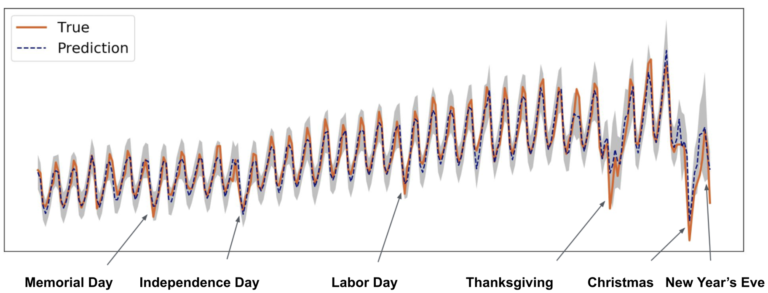

Source: Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber

Example of how uncertainty estimates and predictions intervals can give an understanding of where point predictions (a single number) may not include all of useful information you'd like to know. For example, your model's point prediction for Uber trips on New Years Eve might be 100 (a made up number) but really, the prediction intervals are between 55 and 153 (both made up for the example). In this case, preparing 100 rides might end up being 53 short (it could even be more, like the point prediction, the prediction intervals are also estimates). The image comes from Uber's blog post on uncertainty estimation in neural networks.

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model).
Measure the standard deviation of the predictions.
1. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
To get the prediction interval upper and lower bounds, add and subtract the value obtained to the mean/median of the predictions made.

In [101]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # Take the predictions of multiple randomly initialized deep learning neural networks
  
  # Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)


Use our plotting function as well as the matplotlib.pyplot.fill_between() method to shade in the space between the upper and lower bounds.

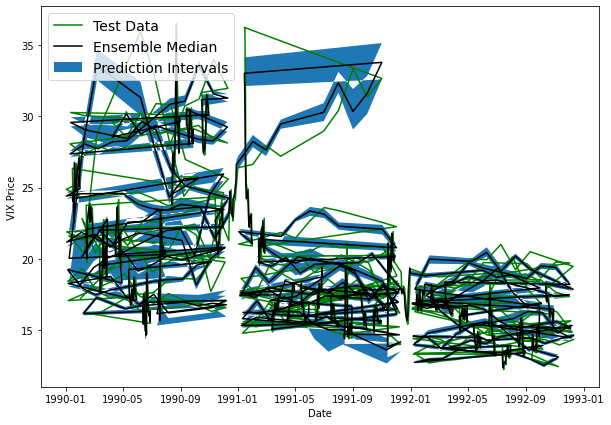

In [102]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=900
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("VIX Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

we just plotted:

1. The test data (the ground truth of vix)
2. The median of the ensemble predictions
3. The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)
4. We can test a hypothesis of overfitting model by creating a model to make predictions into the future and seeing what they look like.
5. Our prediction intervals assume that the data we're using come from a Gaussian/normal distribution (also called a bell curve), however, open systems rarely follow the Gaussian. 6. We'll see this later on with the turkey problem - "The Black Swan" by Nassim Nicholas Taleb, especially Part 2 and Chapter 15.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

What can my model know? (with perfect data, what's possible to learn?)
What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning:

Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
When we measured prediction intervals, we were measuring a form of subway uncertainty for VIX predictions (a little either side of the point prediction).
Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.
The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

References: 1. Evidential Deep Learning and Uncertainty.
2. Uncertainty quantification on Wikipedia.
3. Why you should care about the Nate Silver vs. Nassim Taleb Twitter war by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction.
4. 3 facts about time series forecasting that surprise experienced machine learning practitioners by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
5. Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber - a discussion on techniques 6. Uber used to engineer uncertainty estimates into their time sereis neural networks.

In [103]:
#train model on full historical data to make predictions into the future 

In [104]:
VIX_daily.head()

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82


In [105]:
VIX_daily

,Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82
...,...
1990-08-01,20.26
1990-05-01,20.11
1990-04-01,19.22


In [106]:
# Train model on entire data to make prediction for the next day
X_all = VIX_daily.drop(["Price"], axis=1).dropna().to_numpy()  # only want prices, our future model can be a univariate model
y_all = VIX_daily.dropna()["Price"].to_numpy()

Windows and labels set. turn them into performance optimized TensorFlow Datasets by:

1. Turning X_all and y_all into tensor Datasets using tf.data.Dataset.from_tensor_slices()
2. Combining the features and labels into a Dataset tuple using tf.data.Dataset.zip()
3. Batch and prefetch the data using tf.data.Dataset.batch() and tf.data.Dataset.prefetch() respectively

In [107]:
# Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 0), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

Create a function which returns INTO_FUTURE forecasted values using a trained model.

To do so, we'll build the following steps:

1. Function which takes as input:
a. a list of values (VIX historical data)
b. a trained model (such as model_5)
c. a window into the future to predict (our INTO_FUTURE variable)
d. the window size a model was trained on (WINDOW_SIZE) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last WINDOW_SIZE values from the input values (predictions will start from the last WINDOW_SIZE values of the training data)
3. Loop INTO_FUTURE times making a prediction on WINDOW_SIZE datasets which update to remove the first the value and append the latest prediction
4. Eventually future predictions will be made using the model's own previous predictions as input

In [108]:
# How many timesteps to predict into the future
INTO_FUTURE = 8 # since our VIX data is daily, this is for 14 days

In [109]:
# Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [111]:
model_5.summary()

NameError: ignored

In [112]:

# Make forecasts into future of VIX
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [22.44 22.2  20.26 20.11 19.22 18.19 17.24] -> Prediction: 17.342510223388672

Predicting on: 
 [22.2        20.26       20.11       19.22       18.19       17.24
 17.34251022] -> Prediction: 17.46485710144043

Predicting on: 
 [20.26       20.11       19.22       18.19       17.24       17.34251022
 17.4648571 ] -> Prediction: 17.509706497192383

Predicting on: 
 [20.11       19.22       18.19       17.24       17.34251022 17.4648571
 17.5097065 ] -> Prediction: 17.561967849731445

Predicting on: 
 [19.22       18.19       17.24       17.34251022 17.4648571  17.5097065
 17.56196785] -> Prediction: 17.623397827148438

Predicting on: 
 [18.19       17.24       17.34251022 17.4648571  17.5097065  17.56196785
 17.62339783] -> Prediction: 17.692241668701172

Predicting on: 
 [17.24       17.34251022 17.4648571  17.5097065  17.56196785 17.62339783
 17.69224167] -> Prediction: 17.72983741760254

Predicting on: 
 [17.34251022 17.4648571  17.5097065  17.56196785 17.62339783 17

In [113]:
future_forecast[:16]

[17.34251,
 17.464857,
 17.509706,
 17.561968,
 17.623398,
 17.692242,
 17.729837,
 17.766724]

create a function to return a date range from some specified start date to a specified number of days into the future (INTO_FUTURE).

To do so, we'll use a combination of NumPy's datetime64 datatype as well as NumPy's timedelta64 method which helps to create date ranges.

In [114]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [115]:
#The start date of our forecasted dates will be the last date of our dataset.
#Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = VIX_daily.index[+1]
last_timestep

Timestamp('2022-04-19 00:00:00')

In [116]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23',
       '2022-04-24', '2022-04-25', '2022-04-26', '2022-04-27'],
      dtype='datetime64[D]')

In [117]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps, future_forecast

(array(['2022-04-19', '2022-04-20', '2022-04-21', '2022-04-22',
        '2022-04-23', '2022-04-24', '2022-04-25', '2022-04-26',
        '2022-04-27'], dtype='datetime64[D]'),
 array([17.24    , 17.34251 , 17.464857, 17.509706, 17.561968, 17.623398,
        17.692242, 17.729837, 17.766724], dtype=float32))

In [118]:
x.shape

TensorShape([None, 1, 32])

In [119]:
y.shape

(8129,)

In [121]:
VIX_daily.index.shape, prices.shape

((8136,), (8136,))

In [122]:
next_time_steps.shape, future_forecast.shape

((9,), (9,))

ValueError: ignored

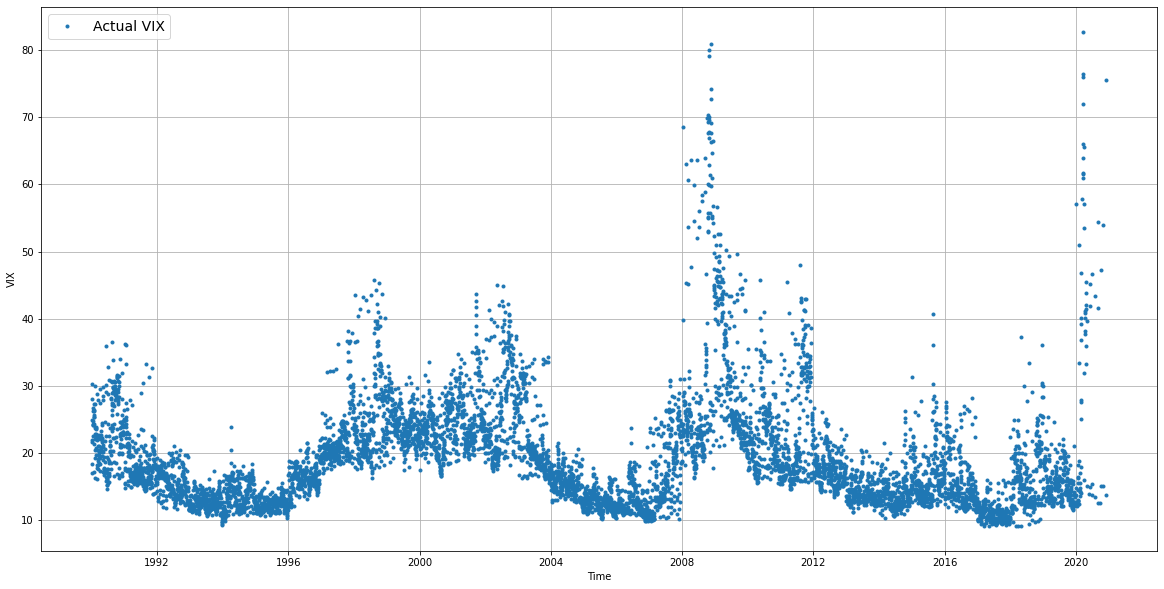

In [125]:
# Initialize
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.pyplot import cm

plt.figure(figsize=(20, 10))

plot_time_series(timesteps = VIX_daily.index, values=VIX_daily, start=500, format=".", label="Actual VIX")
plot_time_series(timesteps= next_time_steps, values=future_forecast[1:], format="+", label="Prediction")

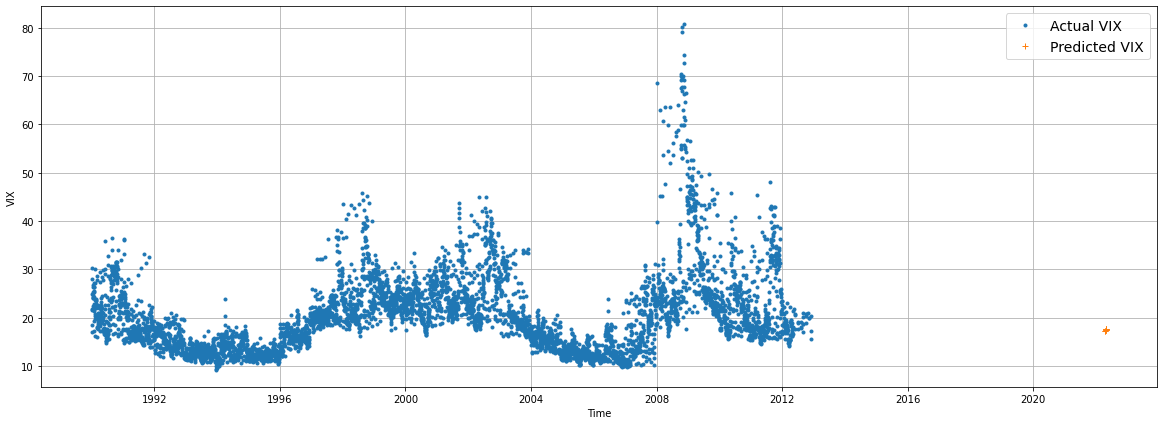

In [124]:
# Plot future price predictions of VIX
plt.figure(figsize=(20, 7))
plot_time_series(VIX_daily.index, VIX_daily, start=2500, format=".", label="Actual VIX")
plot_time_series(next_time_steps, future_forecast, format="+", label="Predicted VIX")

Model 6: The Turkey problem. 
The turkey problem is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

A turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.

Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are.

In other words, how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.

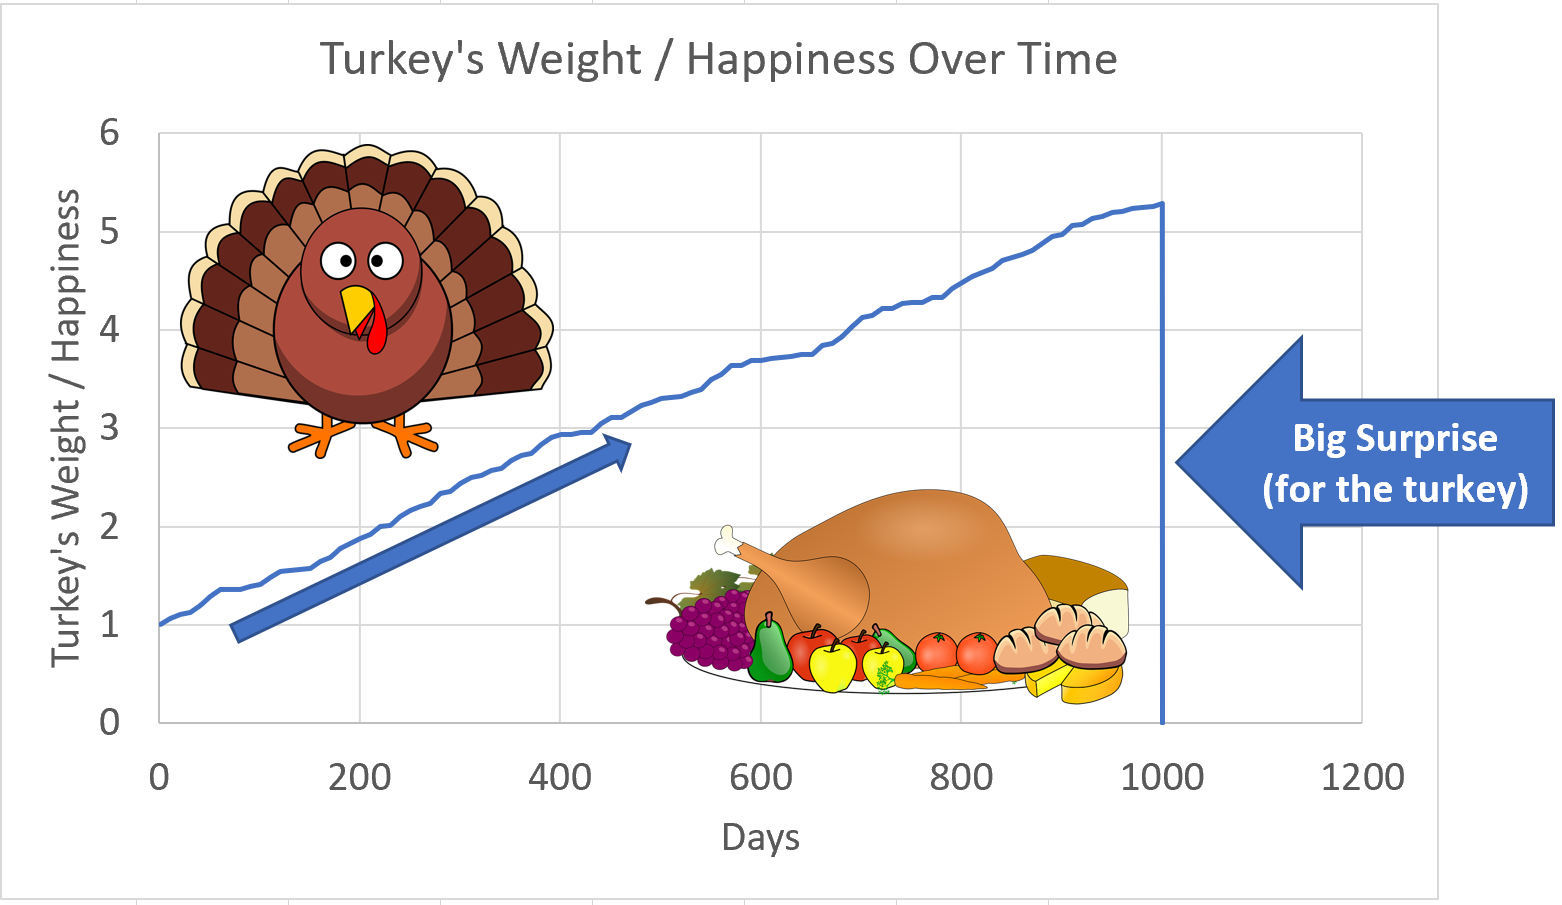

The graph image is from page 41 of The Black Swan by Nassim Taleb (I added in the turkey graphics).

references:
1. Explaining both the XIV trade and why forecasting is BS by Nassim Taleb
2. The Black Swan by Nassim Taleb (epsecially Chapter 4 which outlines and discusses the turkey problem)

In [127]:
VIX_daily=VIX_daily.dropna()

In [128]:
# Let's introduce a Turkey problem to our  data (VIX falls 100x in one day)
VIX_daily_turkey = prices.copy()
VIX_daily_turkey[+1] = VIX_daily_turkey[+1] / 100

In [129]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
#notice last value is 100 x lower
VIX_daily_turkey[+10:]

array([21.03, 18.57, 19.63, ..., 19.22, 18.19, 17.24])

In [130]:
# Get the timesteps for the turkey problem 
vix_timesteps_turkey = np.array(VIX_daily.index)
vix_timesteps_turkey[+10:]

array(['2022-05-04T00:00:00.000000000', '2022-04-04T00:00:00.000000000',
       '2022-01-04T00:00:00.000000000', ...,
       '1990-04-01T00:00:00.000000000', '1990-03-01T00:00:00.000000000',
       '1990-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

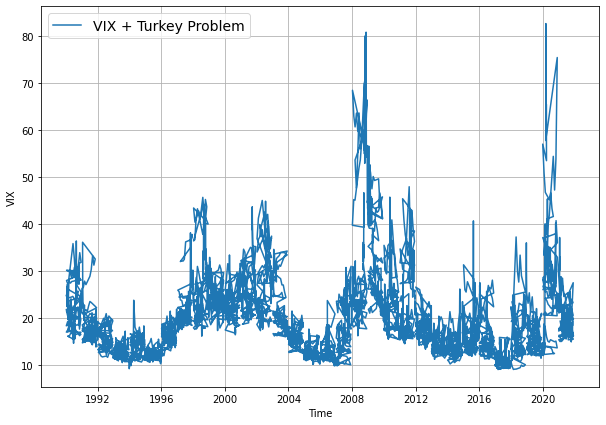

In [131]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=vix_timesteps_turkey, 
                 values=VIX_daily_turkey, 
                 format="-", 
                 label="VIX + Turkey Problem", 
                 start=100)

In [132]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(VIX_daily_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(6503, 1626, 6503, 1626)

In [133]:
#create a turkey_model which is a clone of model_2 (same architecture, but different data).

#That way, when we evaluate the turkey_model we can compare its results to model_2_results and see how much a single data point can influence a model's performance.

In [134]:
# Clone model 2 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_2)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


In [135]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 4ms/step - loss: 0.6810


0.6810485124588013

In [136]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 4ms/step - loss: 0.6810


0.6810485124588013

In [137]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([16.176266, 16.929667, 16.151104, 16.253967, 16.847244, 16.180134,
       16.038773, 17.131014, 16.91207 , 15.61544 ], dtype=float32)>

In [138]:
# Evaluate turkey preds
import numpy as np
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)

turkey_results


{'mae': 4.632292,
 'mape': 28.649061,
 'mase': 6.7394915,
 'mse': 40.440372,
 'rmse': 5.9341946}

In [139]:
model_2_results

{'mae': 0.6810504,
 'mape': 4.1368423,
 'mase': 0.990856,
 'mse': 1.0438161,
 'rmse': 1.0216732}

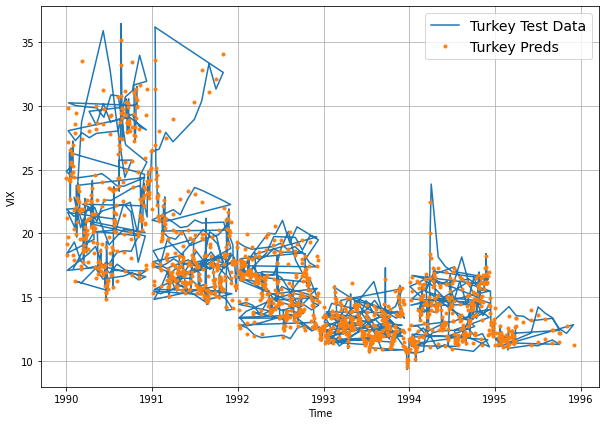

In [140]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=vix_timesteps_turkey[:split_size], values=VIX_daily_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=vix_timesteps_turkey[-len(X_test):], 
                 values=VIX_daily_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=vix_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

We've trained a bunch of models and we've seen just how poorly machine learning and deep learning models are at forecasting

In [141]:
model_2_results

{'mae': 0.6810504,
 'mape': 4.1368423,
 'mase': 0.990856,
 'mse': 1.0438161,
 'rmse': 1.0216732}

In [142]:
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 dense_1 (Dense)             (None, 1, 32)             4128      
                                                                 
 dense_2 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [143]:
model_3.summary()

Model: "model_3_N_Beats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 subtract_00 (Subtract)         (None, 7)            0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                    

In [145]:
model_5.summary()

NameError: ignored

In [146]:
model.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [147]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_CONV1D": model_results,
                              "model_2_LSTM": model_2_results,
                              "model_3_N_BEATs": model_3_results,
                              "model_5_ensemble": ensemble_results,
                              "model_6_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,1.179244,4.284379,2.069874,5.964701,0.999479
model_CONV1D,0.679538,1.049862,1.024628,4.123185,0.988656
model_2_LSTM,0.681050,1.043816,1.021673,4.136842,0.990856
model_3_N_BEATs,0.683179,1.047215,1.023335,4.139392,0.993953
model_5_ensemble,0.680958,1.045524,1.022509,4.130234,0.990722
model_6_turkey,4.632292,40.440372,5.934195,28.649061,6.739491


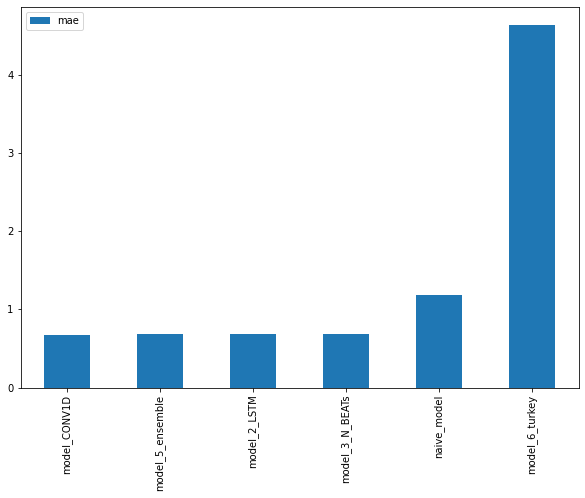

In [148]:
# Sort model results by MAE and plot them

model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar", );